## Conservation of conformational and sequence features across homologs

This notebook reproduces Fig. 4

Authors: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [6]:
import numpy as np
import pandas as pd
import glob 
import time
import random
from joblib import dump, load
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy import stats
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

In [7]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)

In [39]:
# load data for the orthologs
dfs = []
for i in range(4):  
    dfs.append(pd.read_csv(f'idr_orthologs/data/idr_orthologs_and_human_{i:d}.csv.gz',index_col=0))    
df_ortho = pd.concat(dfs)

#### Calculate  standard deviations of Pearson correlation coefficients over 1,000 bootstraps

In [4]:
if not os.path.isfile('idr_orthologs/data/pearson_bootstrap.csv'):
    features = ['z_delta_+-', 'z_omega_pi', 'z_omega_-', 'mean_lambda', 
             'shd', 'scd', 'kappa', 'fcr', 'nu_svr','SPR_svr']
    bootstrap = {}
    for feature in features:
        t0 = time.time()
        bootstrap[feature] = {}
        ortho = df_ortho[feature].astype(float)
        human = df_ortho['human_'+feature].astype(float)
        indices = np.arange(human.size)
        bootstrap_pr = []
        for _ in range(1000):
            picked = random.choices(indices,k=indices.size)
            bootstrap_pr.append(pearsonr(human[picked],ortho[picked])[0])
        bootstrap[feature]['mean'] = np.mean(bootstrap_pr)
        bootstrap[feature]['std'] = np.std(bootstrap_pr)
        print('Time {:.3f}'.format(time.time()-t0))
    bootstrap = pd.DataFrame.from_dict(bootstrap)
    bootstrap.to_csv('idr_orthologs/data/pearson_bootstrap.csv') 
else:
    bootstrap = pd.read_csv('idr_orthologs/data/pearson_bootstrap.csv',index_col=0)

#### Fig. 4

range nu_svr 0.011 0.838
0.809 0.001
range SPR_svr 9.578 11.386
0.9076 0.0004
range mean_lambda 0.1079139941083655 0.7527350612468828
0.8445 0.0004
range z_omega_pi -6.068057276678483 4.0082897049189405
0.697 0.003
range z_delta_+- -6.949292643536767 19.02505696776819
0.7647 0.0008
range z_omega_- -5.80620768216409 23.76654631393603
0.726 0.001


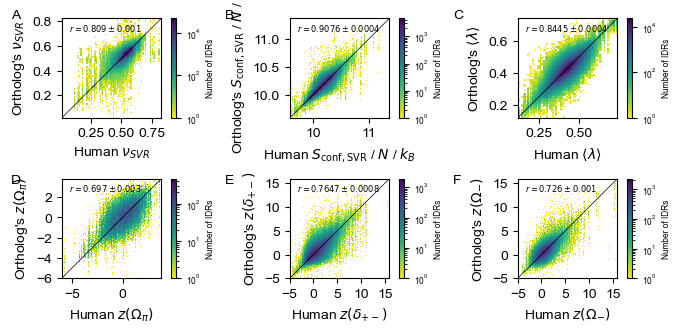

In [5]:
f, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(6.6,3.3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

features = ['nu_svr','SPR_svr','mean_lambda','z_omega_pi','z_delta_+-','z_omega_-']
labels = ['$\\nu_{SVR}$',r'$S_{\mathrm{conf},\mathrm{SVR}}$ / $N$ / $k_B$',
          r'$\langle \lambda \rangle$','$z(\Omega_{\pi})$','$z(\delta_{+-})$','$z(\Omega_{-})$']
intervals = [.01,.01,.01,.1,.1,.1]
decimals = [2,2,2,1,1,1]

for i,feature,label,interval,decimal in zip(range(6),features,labels,intervals,decimals):
    
    ax = axes.flatten()[i]
    ortho = df_ortho[feature].astype(float)
    human = df_ortho['human_'+feature].astype(float)
    
    if feature in ['z_omega_pi','z_delta_+-','z_omega_-','z_omega_h']:
        nonzero_bool = (human != 0)&(ortho != 0)
        human = human[nonzero_bool]
        ortho = ortho[nonzero_bool]
    print('range',feature,human.min(),human.max())
        
    bins = np.round(np.arange(human.min(),human.max(),interval),decimal)
    h,_,_ = np.histogram2d(ortho,human,bins=bins)
    bins_center = bins[:-1] + interval/2
    im = ax.imshow(h, cmap=plt.cm.viridis_r,extent=[bins_center.min(),bins_center.max(),
                                                  bins_center.min(),bins_center.max()],
                     origin='lower',alpha=1,norm=LogNorm(vmin=1,vmax=h.max()),
                    aspect='auto',interpolation='nearest')
    
    ax.set_xlabel('Human '+label)
    ax.set_ylabel("Ortholog's "+label)
    x = np.linspace(human.min(),human.max(),100)
    res = pearsonr(human,ortho)
    pr = res[0]
    ci = res.confidence_interval(confidence_level=0.95)
    
    round_pr = abs(int(np.log10(bootstrap[feature]['std'])))+1
    print(round(pr,round_pr),round(bootstrap[feature]['std'],round_pr))
    
    ax.plot(x,x,lw=.5,zorder=4,color='k',label='$r={:g} \pm {:g}$'.format(
                round(pr,round_pr),round(bootstrap[feature]['std'],round_pr)))
    
    ax.set_xlim(bins_center.min(),bins_center.max())
    ax.set_ylim(bins_center.min(),bins_center.max())
        
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="{:.1f}%".format(5), pad=.1)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation='vertical',
                label='Number of IDRs')
    
    ax.set_aspect('equal')
    ax.legend(frameon=False,handlelength=0,loc='upper left',borderpad=0,handletextpad=.4)
    
axes[1,1].set_xlim(-5,16)
axes[1,1].set_ylim(-5,16)  
axes[1,2].set_xlim(-5,16)
axes[1,2].set_ylim(-5,16)

axes[1,1].set_xticks(range(-5,16,5))
axes[1,2].set_xticks(range(-5,16,5))

f.text(0, .96, 'A', fontsize=10)
f.text(0.325, .96, 'B', fontsize=10)
f.text(0.67, .96, 'C', fontsize=10)

f.text(0, .46, 'D', fontsize=10)
f.text(0.325, .46, 'E', fontsize=10)
f.text(0.67, .46, 'F', fontsize=10)
    
plt.tight_layout(w_pad=4)
plt.savefig('figs/fig4.png',dpi=300)
plt.show()

## Code to generate `idr_orthologs_and_human.csv.gz` containing $\nu_\text{SVR}$, $S_\text{conf,SVR}$, z-scores, and other sequence descriptors of the orthologs

#### Concatenate data for all the homologs of the IDRome

In [63]:
if not os.path.isfile('idr_orthologs/data/orthologs_seq_prop.csv.gz'):
    df_ortho = pd.read_csv('idr_orthologs/data/idr_orthologs.csv.gz',
                           index_col=0,dtype='object',comment='#')
    dfs = []
    for filename in glob.glob('idr_orthologs/data/orthologs/seq_prop_*.csv.gz'):    
        dfs.append(pd.read_csv(filename,index_col=0))

    df_seq_prop = pd.concat(dfs)
    
    df_seq_prop = df_seq_prop[~df_seq_prop.index.duplicated(keep='first')]
    df_seq_prop = df_seq_prop[df_seq_prop.index.isin(df_ortho.idr_ortholog.unique())]

    termini_corr = df_seq_prop.query('termini == True').seq_name
    termini_corr_index = termini_corr.index

    # z-scores affected by changes in terminal charges
    termini_seq_props = ['termini', 'mu_+', 'mu_-', 'h_+', 'h_-', 
       '+_pi', '+_A', '+_P', '+_G', '-_pi', '-_A', '-_P', '-_G', '+_-', '+_+', '-_-']

    # set correct values to sequences with changes to terminal charges
    df_seq_prop.loc[termini_corr,termini_seq_props] = df_seq_prop.query(
        'termini == True').set_index('seq_name')[termini_seq_props]

    df_seq_prop.drop(termini_corr_index,inplace=True)

    df_seq_prop.drop(['nu_svr', 'z_mat', 'z_mat_scr'],axis=1,inplace=True)
    df_seq_prop = df_seq_prop.set_index('seq_name')
    df_seq_prop.to_csv('idr_orthologs/data/orthologs_seq_prop.csv.gz')
else:
    df_seq_prop = pd.read_csv('idr_orthologs/data/orthologs_seq_prop.csv.gz',index_col=0)

#### Calulate $\nu_\text{SVR}$ and $S_\text{conf,SVR}/N$ using the SVR models

In [45]:
model_nu = load('svr_models/svr_model_nu.joblib') 
model_spr = load('svr_models/svr_model_SPR.joblib') 

features_nu = ['scd','shd','kappa','fcr','mean_lambda']
features_spr = ['scd','shd','mean_lambda']

for seq_name in df_seq_prop.index:
    df_seq_prop.loc[seq_name,'nu_svr'] = model_nu.predict(
        df_seq_prop.loc[seq_name,features_nu].values.reshape(1, -1))
    df_seq_prop.loc[seq_name,'SPR_svr'] = model_spr.predict(
        df_seq_prop.loc[seq_name,features_spr].values.reshape(1, -1))

In [46]:
df_seq_prop.nu_svr = df_seq_prop.nu_svr.apply(lambda x: round(x,3))
df_seq_prop.SPR_svr = df_seq_prop.SPR_svr.apply(lambda x: round(x,3))

In [47]:
df_idrome.nu_svr = df_idrome.nu_svr.apply(lambda x: round(x,3))
df_idrome.SPR_svr = df_idrome.SPR_svr.apply(lambda x: round(x,3))

In [52]:
# load data for the orthologs
dfs = []
for i in range(4):  
    dfs.append(pd.read_csv(f'idr_orthologs/data/idr_orthologs_and_human_{i:d}.csv.gz'))    
df_ortho = pd.concat(dfs)df_ortho = df_ortho[['N_FL','human_N_FL','human','fasta','seq_name']]
df_ortho = df_ortho.set_index('seq_name')
df_ortho['first'] = [int(i.split('_')[1]) for i in df_ortho.index]
df_ortho['last'] = [int(i.split('_')[2]) for i in df_ortho.index]
df_ortho['faro'] = df_ortho.fasta.apply(lambda x: sum([x.count(a) for a in ['W','Y','F']])/len(x))

In [54]:
seq_props = ['+_-', 'pi_pi', '-_-', 'mean_lambda', 'fK', 'fR', 'fE', 'fD',
                 'shd', 'scd', 'kappa', 'fcr', 'nu_svr', 'SPR_svr']

df_ortho[seq_props] = df_seq_prop.loc[df_ortho.index,seq_props]

df_ortho.rename({'+_-':'z_delta_+-',  'pi_pi':'z_omega_pi', '-_-':'z_omega_-'},axis=1,inplace=True)

#### Add columns with conformational and sequence feature of human IDRs

In [55]:
features = ['z_delta_+-', 'z_omega_pi', 'z_omega_-', 'fK', 'fR', 'fE', 'fD', 'faro',
            'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'nu_svr', 'SPR_svr']

for feature in features:
    if feature == 'z_delta_+-':
        zero_bool = ((df_idrome.fR+df_idrome.fE)<=.1)&((df_idrome.fK+df_idrome.fD).values<=.1)
        df_idrome.loc[zero_bool,feature] = 0
        zero_bool = ((df_ortho.fR+df_ortho.fE)<=.1)&((df_ortho.fK+df_ortho.fD).values<=.1)
        df_ortho.loc[zero_bool,feature] = 0
    elif feature == 'z_omega_-':
        zero_bool = (df_idrome.fE+df_idrome.fD).values <= .1
        df_idrome.loc[zero_bool,feature] = 0
        zero_bool = (df_ortho.fE+df_ortho.fD).values <= .1
        df_ortho.loc[zero_bool,feature] = 0
    elif feature == 'z_omega_pi':
        zero_bool = df_idrome.faro.values <= .1
        df_idrome.loc[zero_bool,feature] = 0
        zero_bool = df_ortho.faro.values <= .1
        df_ortho.loc[zero_bool,feature] = 0
    df_ortho['human_'+feature] = df_ortho.human.apply(lambda x : df_idrome.loc[x,feature])

In [56]:
df_ortho.loc[df_ortho['z_omega_-'].isnull(),'z_omega_-'] = 0

In [57]:
for i,batch in enumerate(range(0,df_ortho.shape[0],272063)):
    df_ortho.iloc[batch:batch+272063].to_csv(
        f'idr_orthologs/data/idr_orthologs_and_human_{i:d}.csv.gz')